In [ ]:
import numpy as np

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)# 随机生成4组数，每批10000个，1个特征值，
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)#np.newaxis 增加维度

In [7]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)#设置好数据，并增加其复杂度
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]
X_train.shape, y_train.shape #前50个数据作为训练值，最后一个是实际值

((7000, 50, 1), (7000, 1))

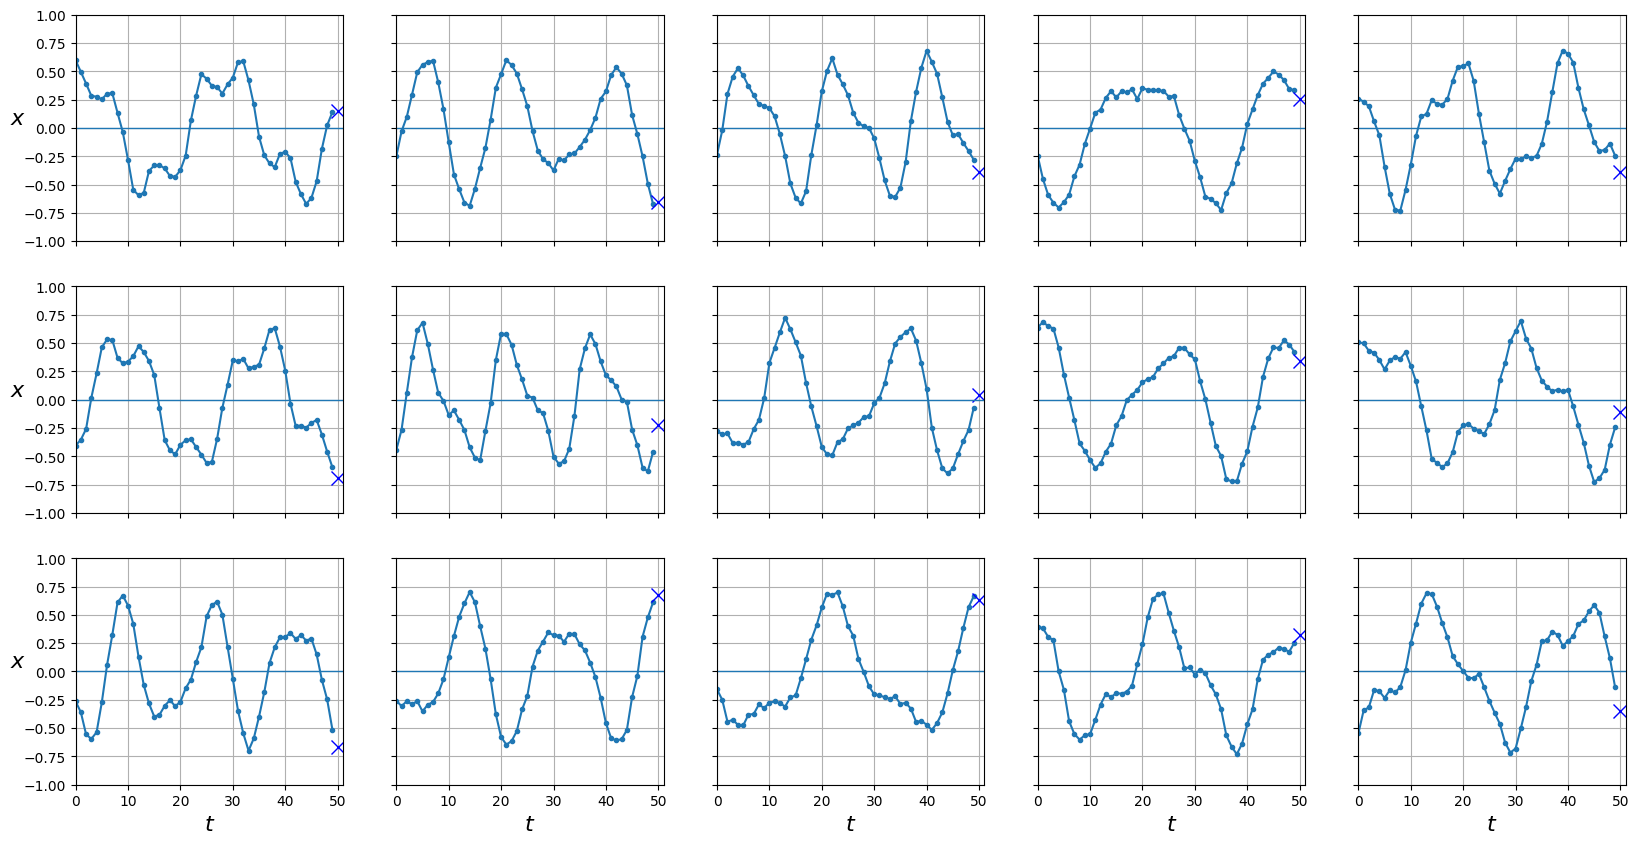

In [ ]:
import matplotlib.pyplot as plt 

def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
    r, c = 3, 5 #前15个
    fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
    for row in range(r):
        for col in range(c):
            plt.sca(axes[row][col])
            ix = col + row*c
            plt.plot(series[ix, :], ".-") #绘制子图，共50个点
            if y is not None: #如果y不为空，则画出y，在每个子图上画出y
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
            if y_pred is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
            if y_pred_std is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
            plt.grid(True)
            plt.hlines(0, 0, 100, linewidth=1)
            plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
            if x_label and row == r - 1:
              plt.xlabel(x_label, fontsize=16)
            if y_label and col == 0:
              plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.show()

plot_series(X_test, y_test) #画出测试集

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train: #如果使用训练，返回x和y
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix]) #将 NumPy 数组 self.X[ix] 转换为 PyTorch 张量，表示输入特征。
    return torch.from_numpy(self.X[ix])#如果不是训练，则返回x

dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [ ]:
class RNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=1, batch_first=True)
    self.fc = torch.nn.Linear(20, 1) #只输出一个预测值，对应的rnn

  def forward(self, x):
    x, h = self.rnn(x) 
    y = self.fc(x[:,-1])
    return y

rnn = RNN()

In [ ]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1)) #进度条
    for epoch in bar:
        model.train()
        train_loss = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device) #将数据移动到设备上
            optimizer.zero_grad()
            y_hat = model(X) #使用模型预测
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        model.eval()
        eval_loss = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} val_loss {np.mean(eval_loss):.5f}")
        
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [16]:
fit(rnn, dataloader)


loss 0.00413 val_loss 0.00404: 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


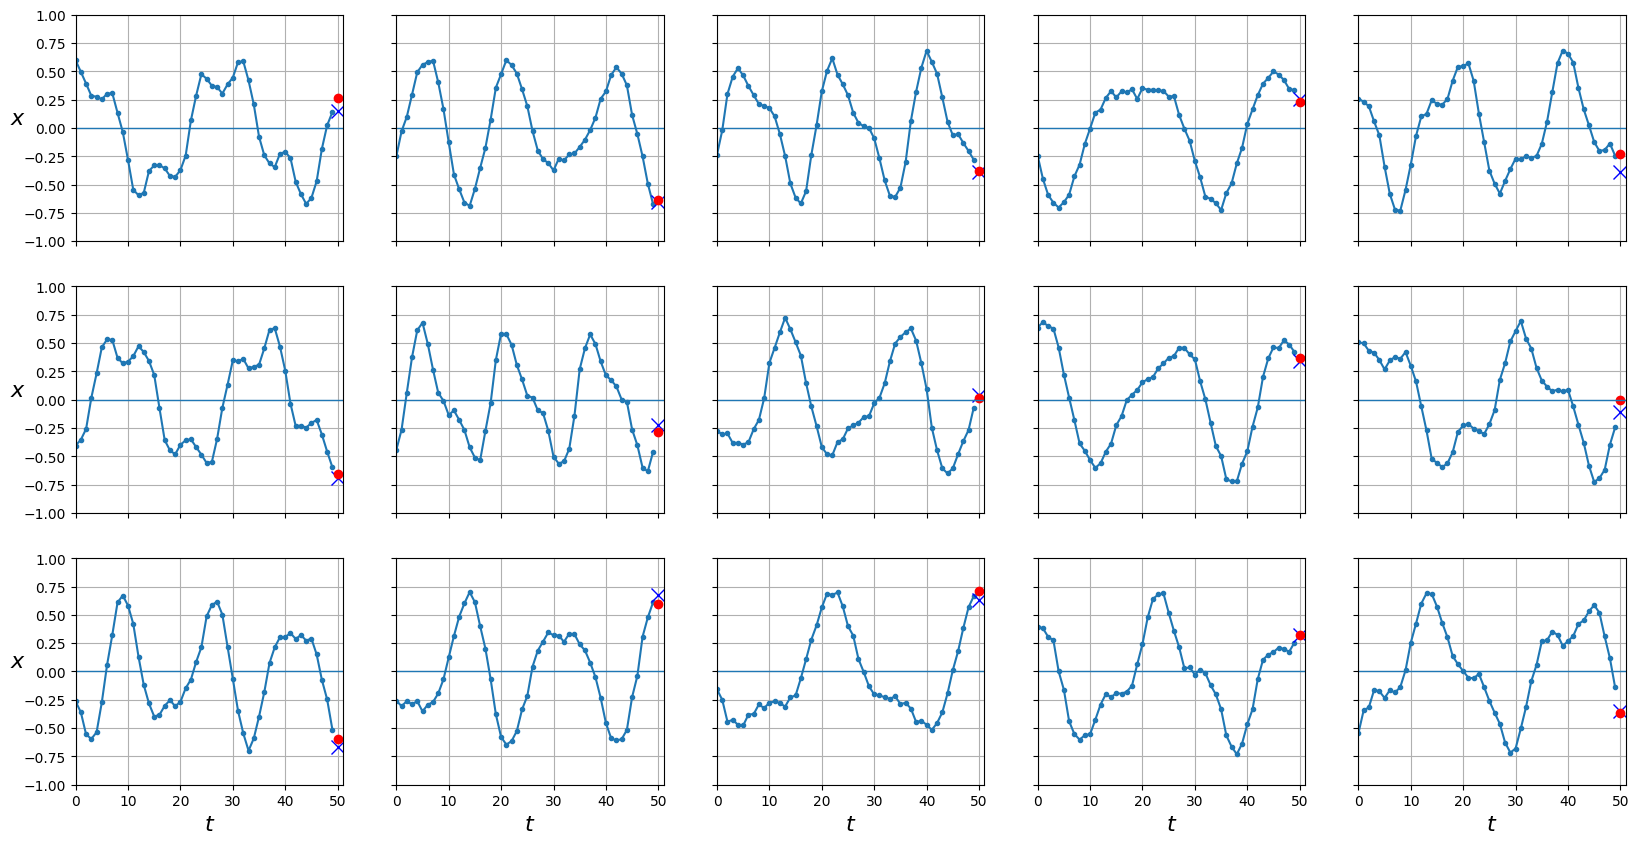

0.0038751617539674044

In [17]:
from sklearn.metrics import mean_squared_error

y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())



In [ ]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0] #将数据切分开，前50个是数据集合，后十个是预测值
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

dataset = {
    'train': TimeSeriesDataset(X_train, Y_train),
    'eval': TimeSeriesDataset(X_valid, Y_valid),
    'test': TimeSeriesDataset(X_test, Y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}



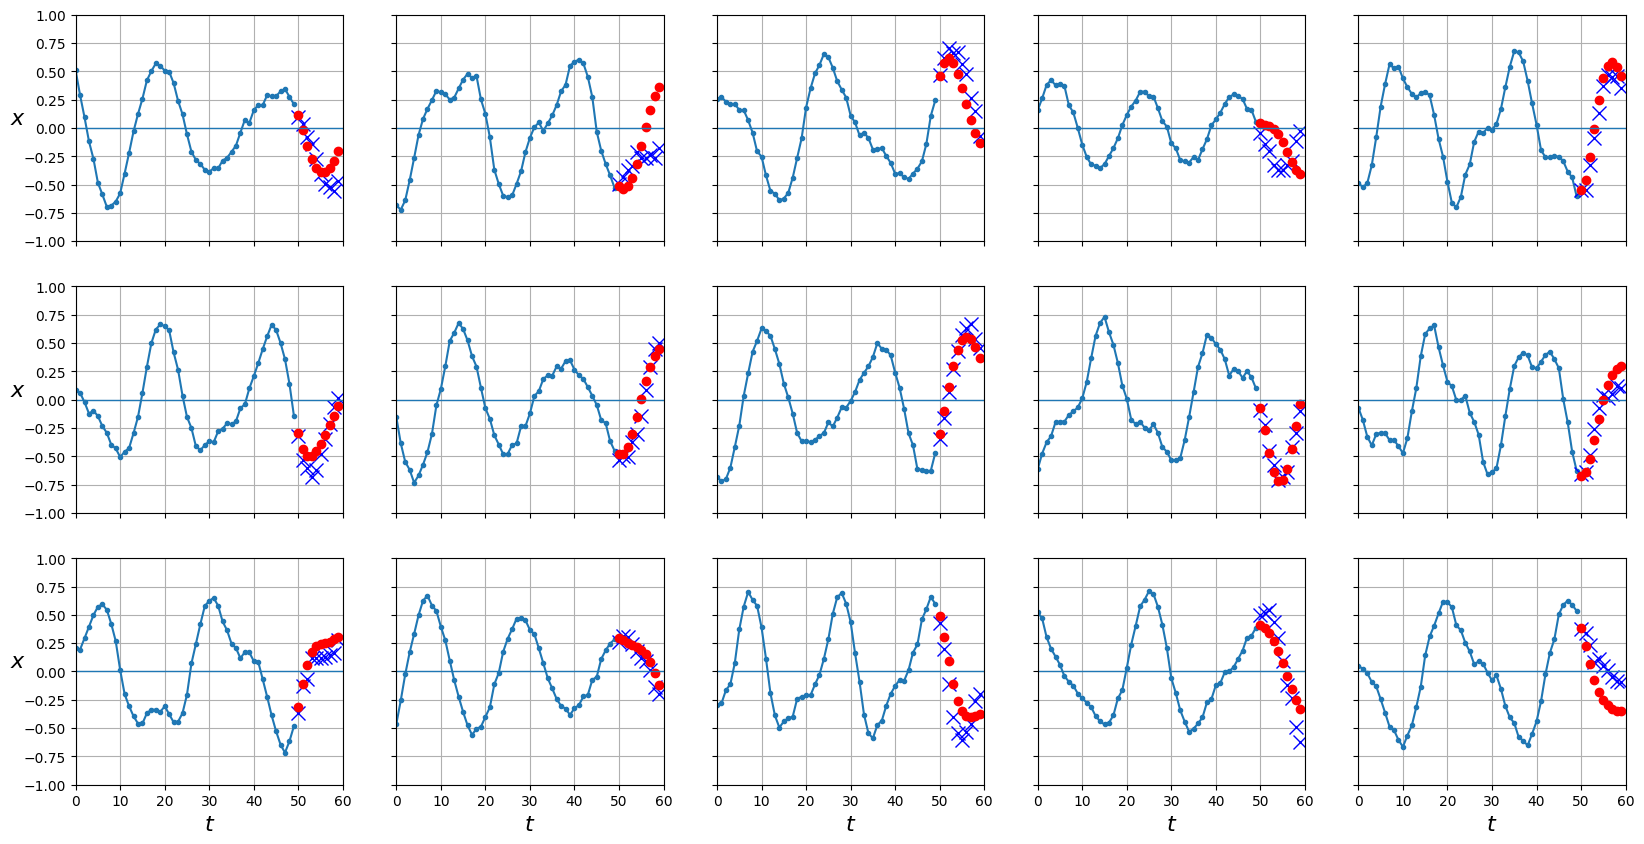

0.03661881759762764

In [ ]:
X = X_test
for step_ahead in range(10):
    inputs = torch.from_numpy(X[:, step_ahead:]).unsqueeze(0)
    y_pred_one = predict(rnn, inputs).cpu().numpy()
    X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)

y_pred = X[:, n_steps:, -1]
plot_series(X_test, Y_test, y_pred)
mean_squared_error(Y_test, y_pred)

